[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Data_visualization.ipynb)

In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#obtaining the data
!gdown https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp

#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#setting the sample 
feat_path = r'/content/features'
participant = 'sub-08'

Downloading...
From: https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
To: /content/features.zip
100% 2.14G/2.14G [00:10<00:00, 198MB/s]


Text(0.5, 1.0, 'sub-08')

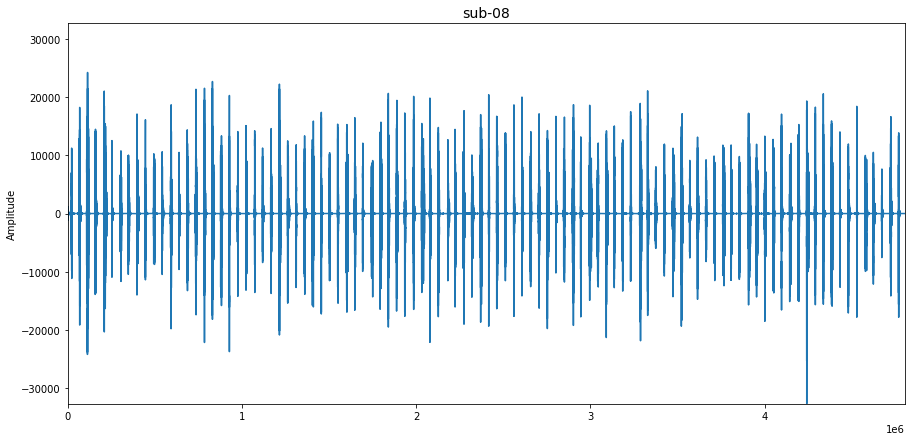

In [4]:
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavefile
import scipy, numpy as np

rate, audio = wavefile.read(os.path.join(feat_path,f'{participant}_orig_audio.wav')) # example file

fig = plt.figure(figsize=(15,7))
plt.plot(audio)
plt.xlim([0,audio.shape[0]])
plt.ylim([-np.max(np.abs(audio)),np.max(np.abs(audio))])
plt.ylabel('Amplitude')
plt.title(participant, fontsize=14)

Length of wavefile in samples: 320000
Sampling rate: 16000
Shape of complex spectrum: (1246, 513) 



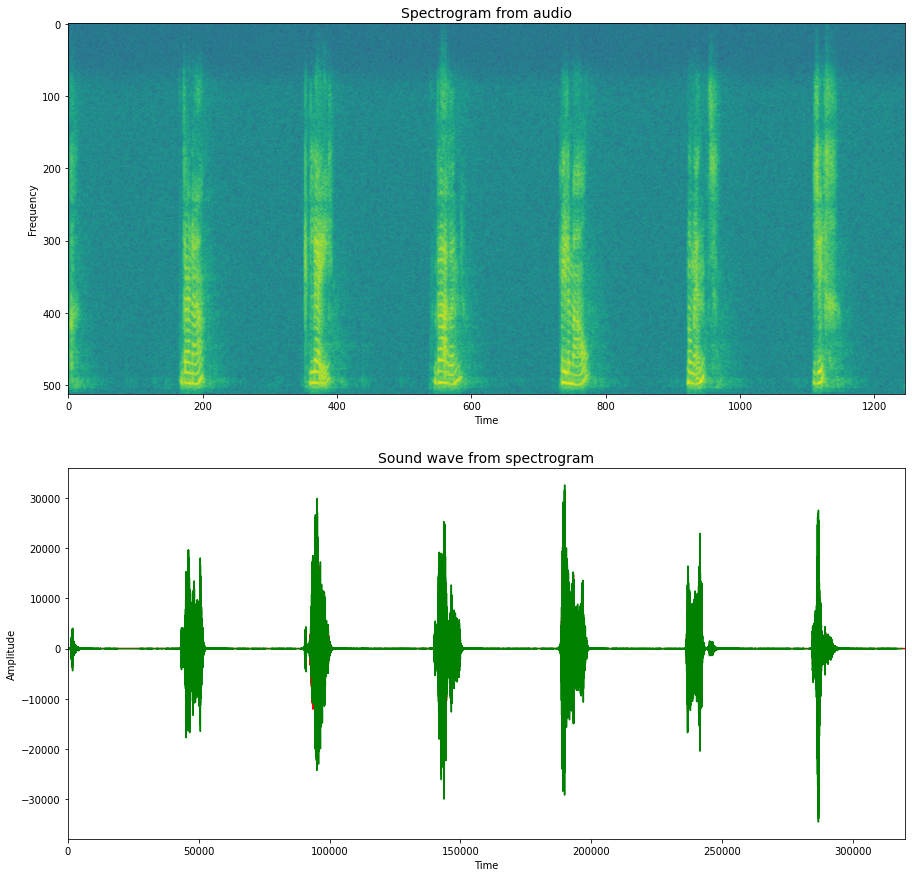

In [5]:
# Wave reconstruction

def stft(x, fftsize=1024, overlap=4):
    # Returns short time fourier transform of a signal x
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]
    return np.array([np.fft.rfft(w*x[i:i+int(fftsize)]) for i in range(0, len(x)-int(fftsize), hop)])

def istft(X, overlap=4):
    #Returns inverse short time fourier transform of a complex spectrum X
    fftsize=(X.shape[1]-1)*2
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]
    x = np.zeros(X.shape[0]*hop)
    wsum = np.zeros(X.shape[0]*hop)
    for n,i in enumerate(range(0, len(x)-fftsize, hop)):
        x[i:i+fftsize] += np.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    return x

def reconstructWavFromSpectrogram(spec,lenWaveFile,fftsize=1024,overlap=4,numIterations=8):
    reconstructedWav = np.random.rand(lenWaveFile*2)
    for i in range(numIterations):
        x=stft(reconstructedWav,fftsize=fftsize,overlap=overlap)
        #print(str(x.shape) + '  ' + str(spec.shape))
        z=spec*np.exp(1j*np.angle(x[:spec.shape[0],:])) #[:spec.shape[0],:spec.shape[1]]
        re=istft(z,overlap=overlap)
        reconstructedWav[:len(re)]=re
    reconstructedWav=reconstructedWav[:len(re)]
    return reconstructedWav


sr, wf = wavefile.read(os.path.join(feat_path,f'{participant}_orig_audio.wav')) # example file
wf = wf[40*sr:60*sr]
print('Length of wavefile in samples: ' + str(wf.shape[0]))
print('Sampling rate: ' + str(sr))
x=stft(wf)
print('Shape of complex spectrum: ' + str(x.shape),'\n')
spectrogram=np.abs(x)

f, (ax1, ax2) = plt.subplots(2,1,figsize=(15, 15))
#ax1.matshow(np.log(spectrogram),aspect='auto')
ax1.imshow(np.flipud(np.log(spectrogram.T)), interpolation=None,aspect='auto')
ax1.set_title('Spectrogram from audio', fontsize=14)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time')

data = reconstructWavFromSpectrogram(spectrogram,len(wf))
ax2.plot(wf,'r',data,'g')
ax2.set_xlim([0,wf.shape[0]])
ax2.set_title('Sound wave from spectrogram', fontsize=14)
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time')

plt.show()

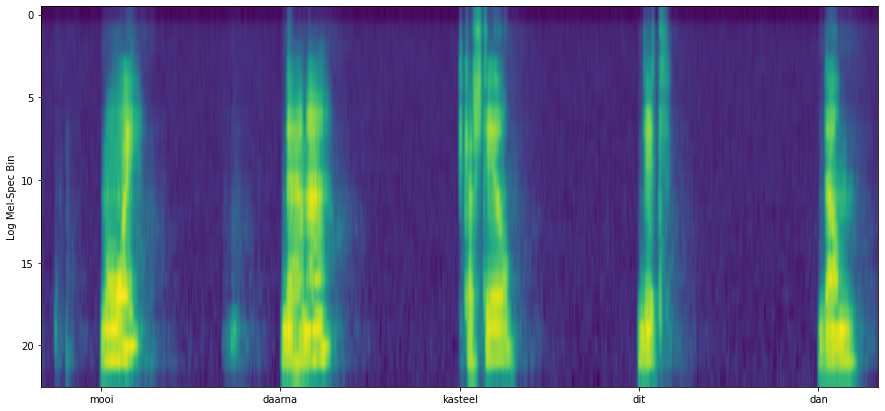

In [6]:
# Plotting spectrogram with words
participant = 'sub-04'

#Which timeframe to plot
start_s = 5.5
stop_s=19.5
frameshift = 0.01

spectrogram = np.load(os.path.join(feat_path, f'{participant}_spec.npy'))

#Load prompted words
eeg_sr= 1024
words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

pSta=int(start_s/frameshift)
pSto=int(stop_s/frameshift)

fig  = plt.figure(figsize=(15,7))
plt.imshow(np.flipud(spectrogram[pSta:pSto, :].T), interpolation=None, aspect='auto')
plt.ylabel('Log Mel-Spec Bin')
plt.xticks(np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), labels=words)
plt.show()